In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [27]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

import pdaactconn as pc
from trialexplorer import AACTStudySet
import utils

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

264682 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['sponsors',
                   'result_groups'])
ss.refresh_dim_data()

Successfuly added these 2 dimensions: ['sponsors', 'result_groups']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 530 chunks x 500 records each

Creating index on the temp table
 - Loading dimension sponsors
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index


In [6]:
ss.studies.shape

(264682, 63)

In [7]:
ss.studies.columns

Index(['nlm_download_date_description', 'study_first_submitted_date',
       'results_first_submitted_date', 'disposition_first_submitted_date',
       'last_update_submitted_date', 'study_first_submitted_qc_date',
       'study_first_posted_date', 'study_first_posted_date_type',
       'results_first_submitted_qc_date', 'results_first_posted_date',
       'results_first_posted_date_type', 'disposition_first_submitted_qc_date',
       'disposition_first_posted_date', 'disposition_first_posted_date_type',
       'last_update_submitted_qc_date', 'last_update_posted_date',
       'last_update_posted_date_type', 'start_month_year', 'start_date_type',
       'start_date', 'verification_month_year', 'verification_date',
       'completion_month_year', 'completion_date_type', 'completion_date',
       'primary_completion_month_year', 'primary_completion_date_type',
       'primary_completion_date', 'target_duration', 'study_type', 'acronym',
       'baseline_population', 'brief_title', 'offic

In [8]:
rg = ss.dimensions['result_groups'].data
sp = ss.dimensions['sponsors'].data

In [9]:
df_ind = sp[(sp['lead_or_collaborator'] == 'lead') & (sp['agency_class'] == 'Industry')]

In [10]:
dfmap = pd.read_csv('matched_reconciled.csv')
name2ticker = dfmap.set_index('name')['yf_ticker'].to_dict()
sp['ticker'] = sp['name'].apply(lambda x: name2ticker[x.lower()] if x.lower() in name2ticker.keys() else np.NaN)
sp_sub = sp[sp['lead_or_collaborator'] == 'lead'].dropna()
mapped_nctids = sp_sub.index.unique()

### reducing the study set

In [11]:
ss.studies = ss.studies.loc[mapped_nctids]
ss.refresh_dim_data()
rg = ss.dimensions['result_groups'].data
sp = ss.dimensions['sponsors'].data

Syncing the temp table temp_cur_studies in 71 chunks x 500 records each

Creating index on the temp table
 - Loading dimension sponsors
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index


In [12]:
sp['ticker'] = sp['name'].apply(lambda x: name2ticker[x.lower()] if x.lower() in name2ticker.keys() else np.NaN)
sp_sub = sp[sp['lead_or_collaborator'] == 'lead']

# verify that the smaller set has all mapped nctids
pd.isnull(sp_sub['ticker']).sum()

0

### Stock data

In [13]:
df_stock = pd.read_pickle('stock_data.p')
sd = pd.Timestamp(df_stock.index.values[0])
ed = pd.Timestamp(df_stock.index.values[-1])

# 1. Phase 2 Factor

In [16]:
ss.studies['phase'].unique()

array(['Phase 3', 'Phase 1', 'Phase 2', 'N/A', 'Phase 4',
       'Phase 2/Phase 3', 'Phase 1/Phase 2', 'Early Phase 1'],
      dtype=object)

In [17]:
accepted_phases = ['Phase 2', 'Phase 1/Phase 2']

In [18]:
df_p2 = ss.studies[ss.studies['phase'].isin(accepted_phases)].copy()

df_p2_sp = df_p2[['start_date']].join(sp_sub)
df_p2_sp['start_date'] = df_p2_sp['start_date'].apply(lambda x: pd.Timestamp(x))
df_p2_sp['ones'] = 1

df_p2_sp = df_p2_sp[(pd.notnull(df_p2_sp['start_date'])) & 
              (df_p2_sp['start_date'] >= sd) & 
              (df_p2_sp['start_date'] <= ed)]

df_p2_sp.head()

,start_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,
NCT00422422,2011-07-31,4376898,Industry,lead,UCB Pharma,UCB.BR,1
NCT00572585,2010-04-30,4359565,Industry,lead,Novartis Pharmaceuticals,NOVN.SW,1
NCT00741884,2010-08-31,4339706,Industry,lead,Pfizer,PFE,1
NCT00790426,2010-03-31,4334310,Industry,lead,Novartis Pharmaceuticals,NOVN.SW,1
NCT00808288,2010-03-31,4332310,Industry,lead,Pfizer,PFE,1


In [19]:
all_counts_p2 = []

for cur_ticker in df_p2_sp['ticker'].unique():
    cur_df = df_p2_sp[df_p2_sp['ticker'] == cur_ticker].sort_values('start_date')
    dfs = cur_df[['start_date', 'ones']].groupby('start_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts_p2.append(dfr)

In [20]:
df_res_p2 = pd.concat(all_counts_p2, axis=1).fillna(method='ffill').fillna(0)
df_res_p2.tail()

,UCB.BR,NOVN.SW,PFE,AZN.ST,MRK,LLY,ABT,GSK.L,JNJ,4523.T,...,REPH,CL,MMM,TXMD,CLAR,CORT,LGND,SOBI.ST,CPRX,CHD
start_date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,8.0,498.0,216.0,218,165.0,156.0,5.0,312.0,156.0,74.0,...,4.0,3.0,3.0,1.0,2.0,6.0,1.0,3.0,2.0,1.0
2020-03-31,8.0,498.0,216.0,218,165.0,157.0,5.0,312.0,156.0,74.0,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-01,8.0,498.0,216.0,218,165.0,157.0,5.0,312.0,157.0,74.0,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-02,8.0,498.0,216.0,218,165.0,157.0,5.0,312.0,157.0,74.0,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-03,8.0,498.0,216.0,219,165.0,157.0,5.0,312.0,157.0,74.0,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0


In [21]:
df_mc = pd.read_pickle('marketcaps.p')
df_mc.head()

,mc,ccy,fx,mc_usd
ticker,,,,
4188.T,873800400896,JPY,0.009178,8.01974e+09
4503.T,2998932602880,JPY,0.009178,2.75242e+10
4506.T,508142845952,JPY,0.009178,4.66374e+09
4507.T,1567943294976,JPY,0.009178,1.43906e+10
4519.T,6800247619584,JPY,0.009178,6.24127e+10


In [22]:
df_tri = df_stock / df_stock[-1:].values
df_hist_mc = df_tri * df_mc['mc_usd'].T
df_hist_mc.tail()

,4188.T,4502.T,4503.T,4506.T,4507.T,4519.T,4523.T,4568.T,4578.T,4768.T,...,TXMD,UCB.BR,UTHR,VIFN.SW,VNDA,VRTX,XENT,XERS,ZBH,ZGNX
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,8.705210e+09,4.839533e+10,2.940241e+10,5.258097e+09,1.513242e+10,6.233730e+10,2.059484e+10,4.557249e+10,2.137606e+10,7.978066e+09,...,2.671740e+08,1.565912e+10,4.223936e+09,8.463449e+09,6.790056e+08,5.917369e+10,3.652160e+08,8.858236e+07,2.015934e+10,1.352199e+09
2020-03-31,8.376810e+09,4.786001e+10,2.853160e+10,5.115888e+09,1.482844e+10,6.281469e+10,2.085250e+10,4.420484e+10,2.105753e+10,8.056538e+09,...,2.646770e+08,1.638070e+10,4.126464e+09,8.888782e+09,7.274558e+08,6.071222e+10,3.718049e+08,7.960165e+07,2.073368e+10,1.307267e+09
2020-04-01,8.108356e+09,4.665917e+10,2.743029e+10,4.805944e+09,1.416468e+10,6.075436e+10,1.918819e+10,4.163009e+10,2.030103e+10,7.943189e+09,...,2.496953e+08,1.687005e+10,4.085995e+09,8.838938e+09,6.783034e+08,5.753054e+10,3.303887e+08,7.184559e+07,1.838504e+10,1.221103e+09
2020-04-02,8.060138e+09,4.545833e+10,2.714856e+10,4.714785e+09,1.403919e+10,6.067899e+10,1.853088e+10,4.079761e+10,1.970877e+10,7.803682e+09,...,2.496953e+08,1.633509e+10,4.069895e+09,8.872167e+09,7.737996e+08,6.178639e+10,3.077980e+08,6.368132e+07,1.901681e+10,1.225860e+09
2020-04-03,8.019740e+09,4.583450e+10,2.752420e+10,4.663735e+09,1.439058e+10,6.241267e+10,1.885165e+10,4.025055e+10,1.998251e+10,7.603140e+09,...,2.496953e+08,1.633509e+10,4.069895e+09,8.872167e+09,7.737996e+08,6.178639e+10,3.077980e+08,6.368132e+07,1.901681e+10,1.225860e+09


In [23]:
has_p2_cols = df_res_p2.columns
df_res_p2_mc = df_hist_mc[has_p2_cols]
dfj_p2 = df_res_p2_mc.add_suffix("_mc").join(df_res_p2, how='left')

In [24]:
dfj_p2.tail()

,UCB.BR_mc,NOVN.SW_mc,PFE_mc,AZN.ST_mc,MRK_mc,LLY_mc,ABT_mc,GSK.L_mc,JNJ_mc,4523.T_mc,...,REPH,CL,MMM,TXMD,CLAR,CORT,LGND,SOBI.ST,CPRX,CHD
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,1.565912e+10,1.822479e+11,1.854871e+11,1.125412e+11,1.935917e+11,1.301441e+11,1.399281e+11,9.076106e+10,3.533471e+11,2.059484e+10,...,4.0,3.0,3.0,1.0,2.0,6.0,1.0,3.0,2.0,1.0
2020-03-31,1.638070e+10,1.870501e+11,1.853168e+11,1.139382e+11,1.935666e+11,1.304073e+11,1.391698e+11,9.275756e+10,3.483529e+11,2.085250e+10,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-01,1.687005e+10,1.848247e+11,1.802637e+11,1.131435e+11,1.856670e+11,1.282451e+11,1.350428e+11,9.182668e+10,3.421897e+11,1.918819e+10,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-02,1.633509e+10,1.892286e+11,1.866226e+11,1.122079e+11,1.933905e+11,1.336599e+11,1.401045e+11,9.144697e+10,3.537191e+11,1.853088e+10,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0
2020-04-03,1.633509e+10,1.892286e+11,1.866226e+11,1.122079e+11,1.933905e+11,1.336599e+11,1.401045e+11,9.144697e+10,3.537191e+11,1.885165e+10,...,4.0,3.0,3.0,1.0,2.0,7.0,1.0,3.0,2.0,1.0


In [25]:
tickers = df_res_p2.columns

for ticker in tickers:
    dfj_p2[ticker + "_factor"] = dfj_p2[ticker] / dfj_p2[ticker + '_mc']
    
df_factor_p2 = dfj_p2[[x for x in dfj_p2.columns if '_factor' in x]]    

In [26]:
df_factor_p2.tail()

,UCB.BR_factor,NOVN.SW_factor,PFE_factor,AZN.ST_factor,MRK_factor,LLY_factor,ABT_factor,GSK.L_factor,JNJ_factor,4523.T_factor,...,REPH_factor,CL_factor,MMM_factor,TXMD_factor,CLAR_factor,CORT_factor,LGND_factor,SOBI.ST_factor,CPRX_factor,CHD_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,5.108843e-10,2.732541e-09,1.164502e-09,1.937069e-09,8.523091e-10,1.198672e-09,3.573263e-11,3.437598e-09,4.414922e-10,3.593133e-09,...,2.149763e-08,5.297711e-11,3.902730e-11,3.742879e-09,7.140991e-09,4.609513e-09,8.359495e-10,6.160580e-10,5.111799e-09,6.149895e-11
2020-03-31,4.883795e-10,2.662388e-09,1.165572e-09,1.913319e-09,8.524198e-10,1.203921e-09,3.592734e-11,3.363607e-09,4.478218e-10,3.548735e-09,...,2.105031e-08,5.315274e-11,3.937896e-11,3.778190e-09,6.995257e-09,5.291830e-09,8.185914e-10,6.058511e-10,5.151632e-09,6.210263e-11
2020-04-01,4.742131e-10,2.694445e-09,1.198245e-09,1.926756e-09,8.886881e-10,1.224218e-09,3.702529e-11,3.397705e-09,4.588099e-10,3.856538e-09,...,2.446388e-08,5.380955e-11,4.037570e-11,4.004881e-09,7.508600e-09,5.382366e-09,8.718214e-10,6.049562e-10,5.699362e-09,6.247252e-11
2020-04-02,4.897433e-10,2.631737e-09,1.157416e-09,1.942822e-09,8.531960e-10,1.174623e-09,3.568764e-11,3.411813e-09,4.438551e-10,3.993334e-09,...,2.405330e-08,5.174147e-11,3.897920e-11,4.004881e-09,7.096638e-09,5.243321e-09,8.273519e-10,6.076489e-10,5.478945e-09,6.014406e-11
2020-04-03,4.897433e-10,2.631737e-09,1.157416e-09,1.951734e-09,8.531960e-10,1.174623e-09,3.568764e-11,3.411813e-09,4.438551e-10,3.925386e-09,...,2.405330e-08,5.174147e-11,3.897920e-11,4.004881e-09,7.096638e-09,5.243321e-09,8.273519e-10,6.076489e-10,5.478945e-09,6.014406e-11


# 2. is_fda_regulated_drug

In [58]:
df_fda_drug = ss.studies[(pd.notnull(ss.studies['is_fda_regulated_drug'])) & 
                         (ss.studies['is_fda_regulated_drug'])]


df_fda_drug_sp = df_fda_drug[['is_fda_regulated_drug',
                              'results_first_submitted_date']].join(sp_sub)
df_fda_drug_sp['results_first_submitted_date'] = df_fda_drug_sp['results_first_submitted_date'].apply(lambda x: pd.Timestamp(x))
df_fda_drug_sp['ones'] = 1

df_fda_drug_sp = df_fda_drug_sp[(pd.notnull(df_fda_drug_sp['results_first_submitted_date'])) & 
                                  (df_fda_drug_sp['results_first_submitted_date'] >= sd) & 
                                  (df_fda_drug_sp['results_first_submitted_date'] <= ed)]
df_fda_drug_sp.head()

,is_fda_regulated_drug,results_first_submitted_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,,
NCT00045942,True,2017-05-03,4426223,Industry,lead,Novartis Pharmaceuticals,NOVN.SW,1
NCT00070707,True,2019-05-07,4420497,Industry,lead,Merck Sharp & Dohme Corp.,MRK,1
NCT00073528,True,2012-04-19,4420081,Industry,lead,Novartis Pharmaceuticals,NOVN.SW,1
NCT00112112,True,2012-02-27,4413699,Industry,lead,MedImmune LLC,AZN.ST,1
NCT00112437,True,2010-04-13,4413666,Industry,lead,Merck Sharp & Dohme Corp.,MRK,1


In [60]:
all_counts_fda_drug = []

for cur_ticker in df_fda_drug_sp['ticker'].unique():
    cur_df = df_fda_drug_sp[df_fda_drug_sp['ticker'] == cur_ticker].sort_values('results_first_submitted_date')
    dfs = cur_df[['results_first_submitted_date', 'ones']].groupby('results_first_submitted_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts_fda_drug.append(dfr)
    
df_res_fda_drug = pd.concat(all_counts_fda_drug, axis=1).fillna(method='ffill').fillna(0)
df_res_fda_drug.tail()

,NOVN.SW,MRK,AZN.ST,GILD,PBYI,GSK.L,TEVA,ROG.SW,JNJ,4523.T,...,FLXN,VRTX,TBPH,MYL,GE,ACRS,LUN.CO,PG,RB.L,4188.T
results_first_submitted_date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,135.0,118.0,47.0,129.0,14.0,82.0,18.0,59.0,46.0,22.0,...,3.0,8.0,2.0,2.0,1.0,8.0,1.0,1.0,5.0,1.0
2020-03-31,135.0,118.0,47.0,129.0,14.0,82.0,18.0,59.0,46.0,22.0,...,3.0,8.0,2.0,2.0,1.0,8.0,1.0,1.0,5.0,1.0
2020-04-01,135.0,118.0,47.0,129.0,14.0,82.0,18.0,59.0,46.0,22.0,...,3.0,8.0,2.0,2.0,1.0,8.0,1.0,1.0,5.0,1.0
2020-04-02,135.0,118.0,47.0,129.0,14.0,82.0,18.0,59.0,46.0,22.0,...,3.0,8.0,2.0,2.0,1.0,8.0,1.0,1.0,5.0,1.0
2020-04-03,135.0,118.0,47.0,129.0,14.0,82.0,18.0,59.0,46.0,22.0,...,3.0,8.0,2.0,2.0,1.0,8.0,1.0,1.0,5.0,1.0


### Joining with MC

In [62]:
has_fda_drug_cols = df_res_fda_drug.columns
df_res_fda_drug_mc = df_hist_mc[has_fda_drug_cols]
dfj_fda_drug = df_res_fda_drug_mc.add_suffix("_mc").join(df_res_fda_drug, how='left')

In [63]:
tickers = df_res_fda_drug.columns

for ticker in tickers:
    dfj_fda_drug[ticker + "_factor"] = dfj_fda_drug[ticker] / dfj_fda_drug[ticker + '_mc']
    
df_factor_fda_drug = dfj_fda_drug[[x for x in dfj_fda_drug.columns if '_factor' in x]]    

In [64]:
df_factor_fda_drug.tail()

,NOVN.SW_factor,MRK_factor,AZN.ST_factor,GILD_factor,PBYI_factor,GSK.L_factor,TEVA_factor,ROG.SW_factor,JNJ_factor,4523.T_factor,...,FLXN_factor,VRTX_factor,TBPH_factor,MYL_factor,GE_factor,ACRS_factor,LUN.CO_factor,PG_factor,RB.L_factor,4188.T_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,7.407491e-10,6.095301e-10,4.176250e-10,1.328187e-09,4.430569e-08,9.034712e-10,1.767187e-09,2.189532e-10,1.301836e-10,1.068229e-09,...,9.751576e-09,1.351952e-10,1.336238e-09,2.604777e-10,1.493612e-11,1.905771e-07,1.800791e-10,3.500484e-12,9.196235e-11,1.148737e-10
2020-03-31,7.217318e-10,6.096093e-10,4.125045e-10,1.348973e-09,4.425320e-08,8.840250e-10,1.674695e-09,2.152929e-10,1.320500e-10,1.055029e-09,...,1.018525e-08,1.317692e-10,1.333347e-09,2.632729e-10,1.484206e-11,1.869122e-07,1.721371e-10,3.659597e-12,9.271002e-11,1.193772e-10
2020-04-01,7.304218e-10,6.355466e-10,4.154016e-10,1.390832e-09,5.067802e-08,8.929867e-10,1.775533e-09,2.120851e-10,1.344284e-10,1.146538e-09,...,1.143480e-08,1.390566e-10,1.437875e-09,2.752735e-10,1.673949e-11,1.869122e-07,1.709511e-10,3.682024e-12,9.316448e-11,1.233296e-10
2020-04-02,7.134227e-10,6.101644e-10,4.188652e-10,1.310071e-09,5.081592e-08,8.966946e-10,1.852064e-09,2.095220e-10,1.300467e-10,1.187207e-09,...,1.170189e-08,1.294783e-10,1.389881e-09,2.819971e-10,1.707913e-11,1.751249e-07,1.676509e-10,3.518843e-12,9.205144e-11,1.240674e-10
2020-04-03,7.134227e-10,6.101644e-10,4.188652e-10,1.310071e-09,5.081592e-08,8.966946e-10,1.852064e-09,2.095220e-10,1.300467e-10,1.167007e-09,...,1.170189e-08,1.294783e-10,1.389881e-09,2.819971e-10,1.707913e-11,1.751249e-07,1.676509e-10,3.518843e-12,9.205144e-11,1.246923e-10


# 3. is_fda_regulated_device

In [65]:
df_fda_device = ss.studies[(pd.notnull(ss.studies['is_fda_regulated_device'])) & 
                         (ss.studies['is_fda_regulated_device'])]


df_fda_device_sp = df_fda_device[['is_fda_regulated_device',
                                  'results_first_submitted_date']].join(sp_sub)
df_fda_device_sp['results_first_submitted_date'] = df_fda_device_sp['results_first_submitted_date'].apply(lambda x: pd.Timestamp(x))
df_fda_device_sp['ones'] = 1

df_fda_device_sp = df_fda_device_sp[(pd.notnull(df_fda_device_sp['results_first_submitted_date'])) & 
                                  (df_fda_device_sp['results_first_submitted_date'] >= sd) & 
                                  (df_fda_device_sp['results_first_submitted_date'] <= ed)]
df_fda_device_sp.head()

,is_fda_regulated_device,results_first_submitted_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,,
NCT00211510,True,2011-04-01,4401177,Industry,lead,Medtronic Diabetes,MDT,1
NCT00676689,True,2016-05-04,4347242,Industry,lead,Edwards Lifesciences,EW,1
NCT00908947,True,2019-09-06,4320545,Industry,lead,C. R. Bard,BDX,1
NCT01055457,True,2016-08-10,4303450,Industry,lead,"Johnson & Johnson Vision Care, Inc.",JNJ,1
NCT01094743,True,2011-11-07,4298767,Industry,lead,"Johnson & Johnson Vision Care, Inc.",JNJ,1


In [66]:
all_counts_fda_device = []

for cur_ticker in df_fda_device_sp['ticker'].unique():
    cur_df = df_fda_device_sp[df_fda_device_sp['ticker'] == cur_ticker].sort_values('results_first_submitted_date')
    dfs = cur_df[['results_first_submitted_date', 'ones']].groupby('results_first_submitted_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts_fda_device.append(dfr)
    
df_res_fda_device = pd.concat(all_counts_fda_device, axis=1).fillna(method='ffill').fillna(0)
df_res_fda_device.tail()

,MDT,EW,BDX,JNJ,ABT,PHIA.AS,BSX,RMD,GE,ALC.SW,...,CHD,AZN.ST,GSK.L,SAN.PA,MMM,ACRS,PG,AMGN,4768.T,LLY
results_first_submitted_date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,24.0,18.0,5.0,39.0,15.0,8.0,12.0,2.0,6.0,29.0,...,1.0,1.0,12.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0
2020-03-21,24.0,18.0,5.0,39.0,15.0,8.0,12.0,2.0,6.0,29.0,...,1.0,1.0,12.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0
2020-03-22,24.0,18.0,5.0,39.0,15.0,8.0,12.0,2.0,6.0,29.0,...,1.0,1.0,12.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0
2020-03-23,24.0,18.0,5.0,39.0,15.0,8.0,12.0,2.0,6.0,30.0,...,1.0,1.0,12.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0
2020-03-24,24.0,18.0,5.0,39.0,15.0,8.0,12.0,2.0,6.0,30.0,...,1.0,1.0,12.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0


### Fill in the last dates that are missing by ffill. Missing dates because nothing completed in the last x days

In [73]:
dt_idx = pd.date_range(start=df_res_fda_device.index[-1] + pd.Timedelta(days=1), 
                       end=df_hist_mc.index[-1], freq='D')

if len(dt_idx) > 0:
    final_array = df_res_fda_device[-1:].values
    for i in range(len(dt_idx)-1):
        final_array = np.append(final_array, df_res_fda_device[-1:].values, axis=0)

    df_pad = pd.DataFrame(final_array, index=dt_idx, columns = df_res_fda_device.columns)

In [74]:
if len(dt_idx) > 0:
    df_res_fda_device = pd.concat([df_res_fda_device, df_pad])
else:
    pass

### Join with MC

In [75]:
has_fda_device_cols = df_res_fda_device.columns
df_res_fda_device_mc = df_hist_mc[has_fda_device_cols]
dfj_fda_device = df_res_fda_device_mc.add_suffix("_mc").join(df_res_fda_device, how='left')

In [76]:
tickers = df_res_fda_device.columns

for ticker in tickers:
    dfj_fda_device[ticker + "_factor"] = dfj_fda_device[ticker] / dfj_fda_device[ticker + '_mc']
    
df_factor_fda_device = dfj_fda_device[[x for x in dfj_fda_device.columns if '_factor' in x]]    

In [77]:
df_factor_fda_device.tail()

,MDT_factor,EW_factor,BDX_factor,JNJ_factor,ABT_factor,PHIA.AS_factor,BSX_factor,RMD_factor,GE_factor,ALC.SW_factor,...,CHD_factor,AZN.ST_factor,GSK.L_factor,SAN.PA_factor,MMM_factor,ACRS_factor,PG_factor,AMGN_factor,4768.T_factor,LLY_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,1.942778e-10,4.329623e-10,8.512174e-11,1.103730e-10,1.071979e-10,2.244454e-10,2.705964e-10,8.801554e-11,8.961672e-11,1.211938e-09,...,6.149895e-11,8.885638e-12,1.322153e-10,1.794671e-11,1.300910e-11,2.382214e-08,7.000968e-12,8.269914e-12,1.253437e-10,7.683793e-12
2020-03-31,1.983064e-10,4.500402e-10,8.256553e-11,1.119554e-10,1.077820e-10,2.231382e-10,2.623864e-10,9.215070e-11,8.905238e-11,1.197320e-09,...,6.210263e-11,8.776691e-12,1.293695e-10,1.802957e-11,1.312632e-11,2.336402e-08,7.319194e-12,8.504472e-12,1.241228e-10,7.668283e-12
2020-04-01,2.126176e-10,4.917255e-10,8.416629e-11,1.139719e-10,1.110759e-10,2.301522e-10,2.835929e-10,9.538883e-11,1.004369e-10,1.201217e-09,...,6.247252e-11,8.838331e-12,1.306810e-10,1.830364e-11,1.345857e-11,2.336402e-08,7.364047e-12,8.715999e-12,1.258940e-10,7.797569e-12
2020-04-02,2.075829e-10,4.591939e-10,8.132322e-11,1.102570e-10,1.070629e-10,2.289368e-10,2.757381e-10,9.040749e-11,1.024748e-10,1.241358e-09,...,6.014406e-11,8.912026e-12,1.312236e-10,1.817928e-11,1.299307e-11,2.189061e-08,7.037686e-12,8.254077e-12,1.281446e-10,7.481674e-12
2020-04-03,2.075829e-10,4.591939e-10,8.132322e-11,1.102570e-10,1.070629e-10,2.289368e-10,2.757381e-10,9.040749e-11,1.024748e-10,1.241358e-09,...,6.014406e-11,8.912026e-12,1.312236e-10,1.817928e-11,1.299307e-11,2.189061e-08,7.037686e-12,8.254077e-12,1.315246e-10,7.481674e-12


### Computing TRI for new factors

In [78]:
tri_p2 = utils.compute_factor_tri(df_factor_p2, df_stock, quantile_size=0.1)
tri_p2.name = 'factor_phase2'

tri_fda_drug = utils.compute_factor_tri(df_factor_fda_drug, df_stock, quantile_size=0.1)
tri_fda_drug.name = 'factor_fda_drug'

tri_fda_device = utils.compute_factor_tri(df_factor_fda_device, df_stock, quantile_size=0.1)
tri_fda_device.name = 'factor_fda_device'



## Join to Prev Results

In [79]:
dfr = pd.read_pickle('res.p')
dfj = dfr.join(tri_p2).join(tri_fda_drug).join(tri_fda_device)

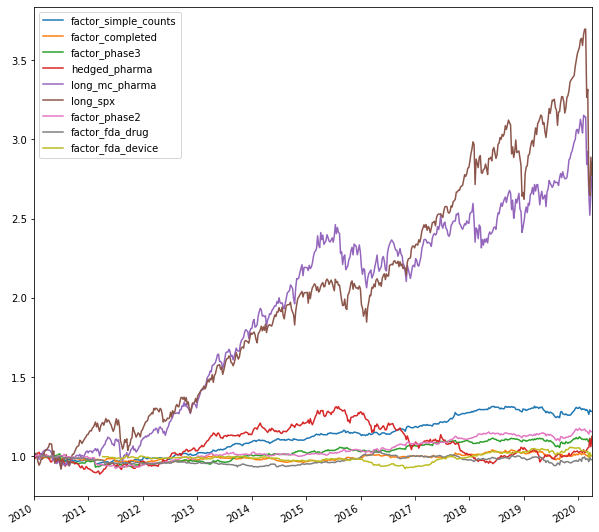

In [82]:
dfj.plot(figsize=(10,10))
plt.show()

In [80]:
utils.compute_sharpe(dfj)

factor_simple_counts    0.711959
factor_completed        0.012644
factor_phase3           0.256772
hedged_pharma           0.151764
long_mc_pharma          0.796342
long_spx                0.688181
factor_phase2           0.416003
factor_fda_drug        -0.066124
factor_fda_device       0.015662
dtype: float64